In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
from sklearn import preprocessing
from scipy.special import boxcox,inv_boxcox

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test_public.csv')
print(train_data.shape)
print(test_data.shape)

(1710670, 9)
(320, 8)


In [3]:
#We delete the rows with missing data
train_data = train_data.drop(train_data[train_data.MISSING_DATA == True].index)
print(train_data.shape)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)

(1710660, 9)
(1710980, 7)


In [4]:
all_features.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,C,NaN,NaN,20000589,1372636858,A,False
1,B,NaN,7.0,20000596,1372637303,A,False
2,C,NaN,NaN,20000320,1372636951,A,False
3,C,NaN,NaN,20000520,1372636854,A,False
4,C,NaN,NaN,20000337,1372637091,A,False


In [5]:
#standardize numeric entry values
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,C,NaN,NaN,1.138373,-1.740697,A,NaN
1,B,NaN,-1.311269,1.171511,-1.740649,A,NaN
2,C,NaN,NaN,-0.135066,-1.740687,A,NaN
3,C,NaN,NaN,0.811729,-1.740697,A,NaN
4,C,NaN,NaN,-0.054588,-1.740672,A,NaN


In [6]:
#create one-hot columns for discrete values
all_features = pd.get_dummies(all_features, dummy_na=False)
all_features.head()

,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A
0,NaN,NaN,1.138373,-1.740697,NaN,0,0,1,1
1,NaN,-1.311269,1.171511,-1.740649,NaN,0,1,0,1
2,NaN,NaN,-0.135066,-1.740687,NaN,0,0,1,1
3,NaN,NaN,0.811729,-1.740697,NaN,0,0,1,1
4,NaN,NaN,-0.054588,-1.740672,NaN,0,0,1,1


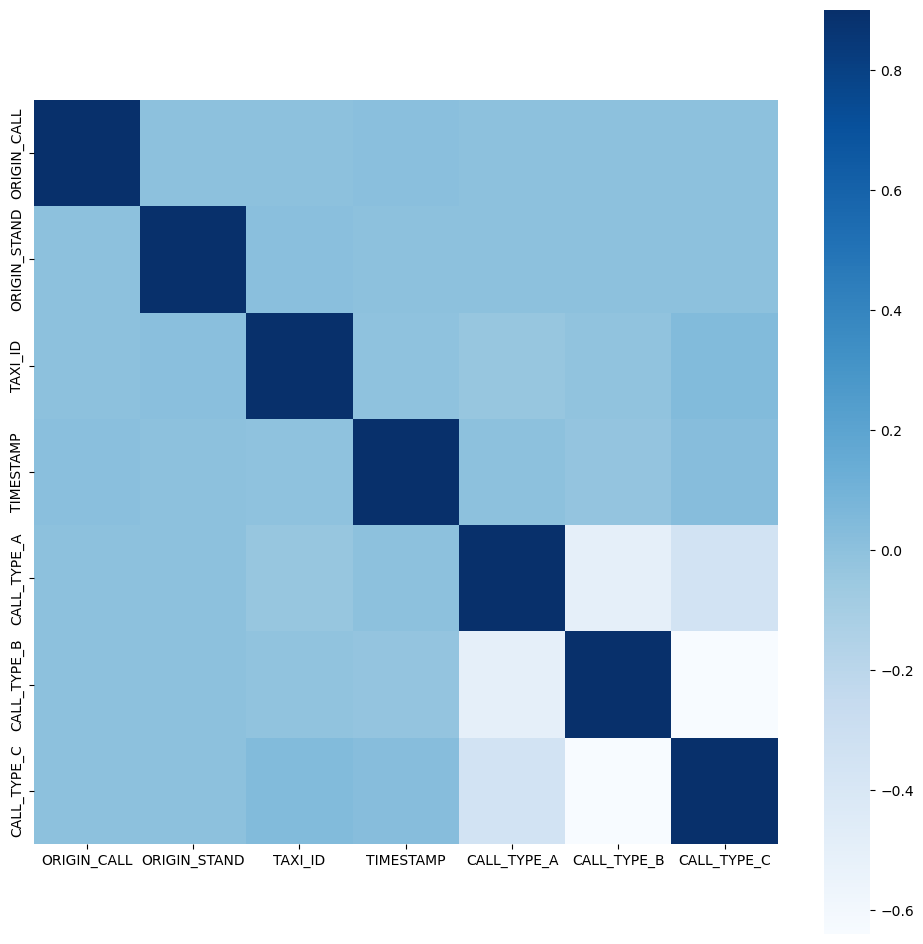

In [7]:
#It seems that all data's day types are A, so we remove the last column; we also delete missing_data column as it is not useful
#Fill NaN values with 0
all_features = all_features.drop(['MISSING_DATA','DAY_TYPE_A'],axis=1)
all_features = all_features.fillna(0)
all_features.head()
def draw_corr_picture(X):
    corrmat = X.corr()
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(all_features)

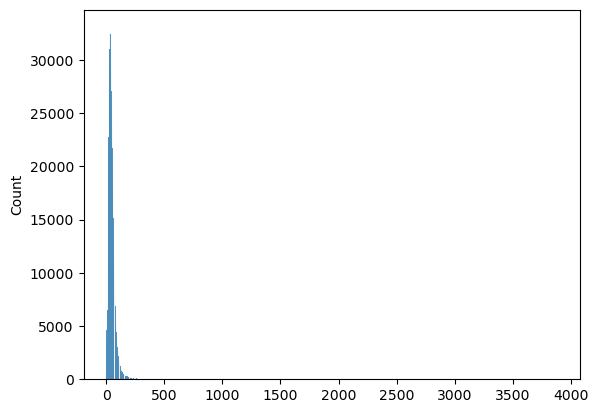

In [8]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_label = train_data["POLYLINE"].apply(lambda x : max(x.count("[") - 1, 0))
train_label = torch.tensor(train_label, dtype = torch.int32)
sns.histplot(train_label)
plt.show()

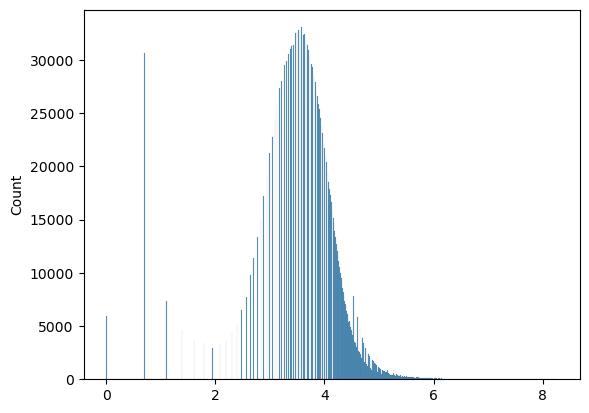

In [9]:
#log(x+1) transformation of POLYLINE coordinates to standardize it, need to do 15*(e^(predict) - 1) later
train_label = torch.log(train_label + 1)
sns.histplot(train_label)
plt.show()

In [10]:
#Tasks and something to think about

#For the taxi-id and call-id, we may need to change it to categorical feature(using one-hot or embedding(don't know what that is))

#Do we need to remove the rows with 0,1, ... coordinate points in PIPELINE?(It seems weird to have a trip within 1 minute)

#building model

#Use sklearn for something like gradient boosting or random forest, manually build a neural network

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

#Try Ensemble Learning, maybe stacking different models